In [1]:
class Street:
    def __init__(self, street_length=1000, segment_length=5, street_width=2.0, building_gap=20.0):
        self.street_length = street_length
        self.segment_length = segment_length
        self.street_width = street_width
        self.building_gap = building_gap
        self.points = []  # Stores road segment points
        self.building_positions = []  # Stores building positions

    def create_street(self):
        """Creates road segments with curvature and stores points."""
        curve_factor = random.uniform(0, self.street_length / 4)  # Random curve factor
        angle_offset = random.uniform(0, 2 * math.pi)  # Random starting angle
        start_x = random.uniform(-10, 10)
        start_y = random.uniform(-10, 10)
        self.points = []
        for i in range(int(self.street_length * 5)):  # Every 20 cm
            t = i / (self.street_length * 5)
            angle = t * 2 * math.pi + angle_offset
            x = start_x + t * self.street_length + math.sin(angle) * curve_factor
            y = start_y + math.cos(angle) * curve_factor
            self.points.append((x, y))


In [2]:
class Building:
    dist = 5  # Minimum distance between buildings
    sidewalk = 5  # Width of the sidewalk
    data = {
        'Big': {'Height': [50, 10], 'Width': [30, 5], 'Depth': [25, 4]},
        'Mean': {'Height': [30, 8], 'Width': [20, 4], 'Depth': [15, 3]},
        'Small': {'Height': [15, 5], 'Width': [10, 2], 'Depth': [8, 2]}
    }

    def __init__(self, street_width):
        self.street_size = self.determine_street_size(street_width)
        height = max(5, random.gauss(self.data[self.street_size]['Height'][0], self.data[self.street_size]['Height'][1]))
        width = max(5, random.gauss(self.data[self.street_size]['Width'][0], self.data[self.street_size]['Width'][1]))
        depth = max(5, random.gauss(self.data[self.street_size]['Depth'][0], self.data[self.street_size]['Depth'][1]))
        self.size = [height, width, depth]
        self.center_location = (0, 0)  # Will be set later
        self.rotation = 0  # Will be set later

    def determine_street_size(self, street_width):
        if street_width > 19:
            return 'Big'
        elif 11 <= street_width <= 19:
            return 'Mean'
        else:
            return 'Small'

def create_building(building):
    bpy.ops.mesh.primitive_cube_add(size=1)
    obj = bpy.context.active_object
    # Set scale
    obj.scale = (building.size[1], building.size[2], building.size[0])
    # Set location and rotation
    obj.location = (building.center_location[0], building.center_location[1], building.size[0] / 2)
    obj.rotation_euler[2] = building.rotation



def check_collision(new_building, existing_buildings, city_streets):
    # Check collision with existing buildings
    for existing in existing_buildings:
        dx = abs(new_building.center_location[0] - existing.center_location[0])
        dy = abs(new_building.center_location[1] - existing.center_location[1])
        min_distance = max(new_building.size[1], new_building.size[2]) / 2 + \
                       max(existing.size[1], existing.size[2]) / 2 + Building.dist
        if dx < min_distance and dy < min_distance:
            return True
    
    # Check collision with streets
    for street in city_streets:
        for i in range(len(street.points) - 1):
            p1 = street.points[i]
            p2 = street.points[i + 1]
            
            # Calculate the direction vector of the street segment
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            length = math.sqrt(dx*dx + dy*dy)
            if length == 0:
                continue
            
            # Normalize the direction vector
            dx /= length
            dy /= length
            
            # Calculate the perpendicular vector
            px = -dy
            py = dx
            
            # Calculate the four corners of the street segment
            half_width = street.street_width / 2
            street_corners = [
                (p1[0] + px * half_width, p1[1] + py * half_width),
                (p1[0] - px * half_width, p1[1] - py * half_width),
                (p2[0] - px * half_width, p2[1] - py * half_width),
                (p2[0] + px * half_width, p2[1] + py * half_width)
            ]
            
            # Check if the building intersects with this street segment
            if polygon_rectangle_intersection(street_corners, new_building):
                return True
    
    return False

def polygon_rectangle_intersection(polygon, building):
    # Check if any corner of the building is inside the polygon
    building_corners = get_building_corners(building)
    for corner in building_corners:
        if point_in_polygon(corner, polygon):
            return True
    
    # Check if any edge of the building intersects with any edge of the polygon
    for i in range(len(polygon)):
        p1 = polygon[i]
        p2 = polygon[(i+1) % len(polygon)]
        for j in range(len(building_corners)):
            b1 = building_corners[j]
            b2 = building_corners[(j+1) % len(building_corners)]
            if line_intersection(p1, p2, b1, b2):
                return True
    
    return False

def get_building_corners(building):
    half_width = building.size[1] / 2
    half_depth = building.size[2] / 2
    return [
        (building.center_location[0] - half_width, building.center_location[1] - half_depth),
        (building.center_location[0] + half_width, building.center_location[1] - half_depth),
        (building.center_location[0] + half_width, building.center_location[1] + half_depth),
        (building.center_location[0] - half_width, building.center_location[1] + half_depth)
    ]

def point_in_polygon(point, polygon):
    x, y = point
    n = len(polygon)
    inside = False
    p1x, p1y = polygon[0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

def line_intersection(p1, p2, p3, p4):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4
    
    den = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if den == 0:
        return False
    
    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / den
    u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / den
    
    return 0 <= t <= 1 and 0 <= u <= 1

[166.19208921135075, 166.31515182877996, 166.4379426553115, 166.56046181286928, 166.68270942380602, 166.8046856109034, 166.9263904973717, 167.04782420684955, 167.1689868634039, 167.2898785915296, 167.41049951614946, 167.53084976261388, 167.65092945670068, 167.77073872461492, 167.8902776929887, 168.009546488881, 168.12854523977745, 168.24727407358998, 168.36573311865695, 168.48392250374258, 168.60184235803703, 168.7194928111561, 168.83687399314087, 168.95398603445784, 169.0708290659983, 169.18740321907853, 169.30370862543933, 169.41974541724582, 169.53551372708745, 169.65101368797747, 169.76624543335305, 169.88120909707482, 169.9959048134267, 170.1103327171159, 170.22449294327234, 170.33838562744882, 170.45201090562054, 170.5653689141849, 170.6784597899615, 170.79128367019166, 170.9038406925384, 171.01613099508614, 171.12815471634045, 171.23991199522789, 171.3514029710957, 171.46262778371175, 171.57358657326424, 171.68427948036128, 171.79470664603105, 171.90486821172124, 172.01476431929

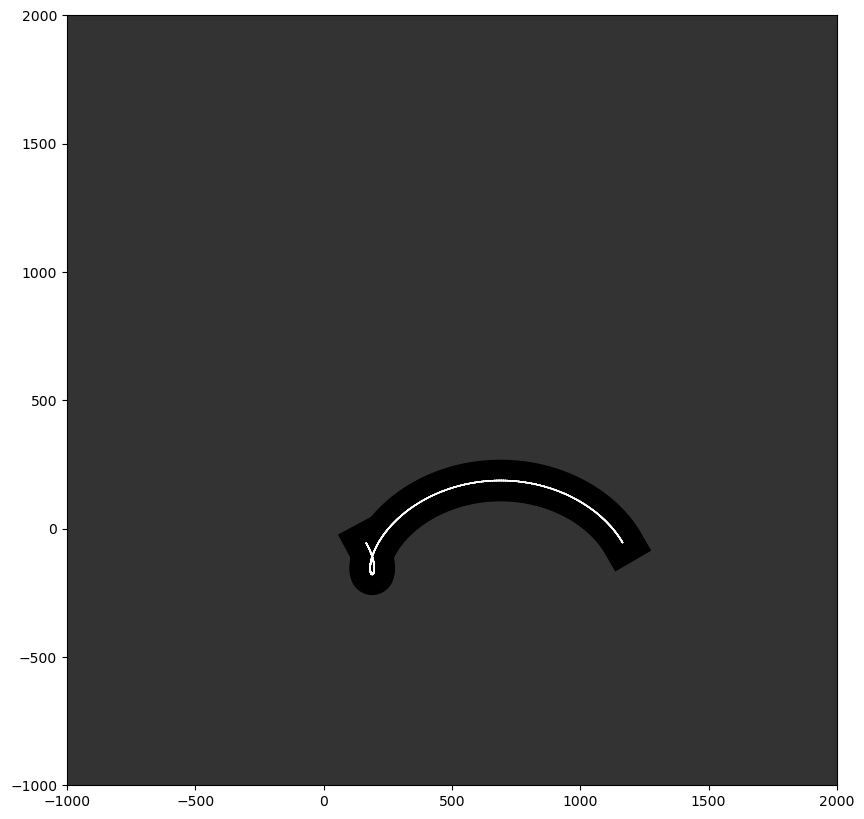

In [90]:
import matplotlib.pyplot as plt
import random
import math

class Street:
    def __init__(self, street_length=1000, segment_length=5, street_width=2.0):
        self.street_length = street_length
        self.segment_length = segment_length
        self.street_width = street_width
        self.points = []  # לשמור את נקודות ההתחלה של המקטעים
    def create_street(self):
        """יוצר מקטעי כביש בצורה הרצויה עם עיקול ושומר את הנקודות."""
        curve_factor = random.uniform(0, self.street_length / 4)  # גורם עיקול רנדומלי
        angle_offset = random.uniform(0, 2 * math.pi)  # זווית התחלתית רנדומלית
        # יצירת נקודת התחלה קרובה לראשית הצירים
        start_x = random.uniform(-10, 10)
        start_y = random.uniform(-10, 10)
        # יצירת נקודות הכביש
        self.points = []
        for i in range(int(self.street_length * 5)):  # כל 20 ס"מ
            t = i / (self.street_length * 5)
            angle = t * 2 * math.pi + angle_offset
            x = start_x + t * self.street_length + math.sin(angle) * curve_factor
            y = start_y + math.cos(angle) * curve_factor
            self.points.append((x, y))
    def draw_road(self):
        """מצייר את הכביש כקו רציף עם רוחב מוגדר."""
        x_vals = [p[0] for p in self.points]
        y_vals = [p[1] for p in self.points]
        # ציור קו האמצע של הכביש
        plt.plot(x_vals, y_vals, color="black", linewidth=self.street_width)
    def draw_dashed_line(self):
        """יוצר קו מקווקו לאורך הכביש."""
        dashed_length = 10
        gap_length = 10
        for i in range(0, len(self.points) - 1, dashed_length + gap_length):
            if i + dashed_length >= len(self.points):
                break
            for j in range(dashed_length):
                if i + j + 1 >= len(self.points):
                    break
                p1 = self.points[i + j]
                p2 = self.points[i + j + 1]
                plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color="white", linewidth=1)
                
    def generate_street(self):
        """מייצרת כביש רנדומלי ומציירת אותו ב-Jupyter Notebook."""
        self.create_street()
        self.draw_road()
        self.draw_dashed_line()
# דוגמת שימוש ב-Jupyter Notebook
street = Street(street_length=1000, street_width=30.0)
# יצירת הכביש
plt.figure(figsize=(10, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_facecolor((0.2, 0.2, 0.2))  # רקע כהה
street.generate_street()
plt.xlim(-1000, 2000)
plt.ylim(-1000, 2000)
plt.show()

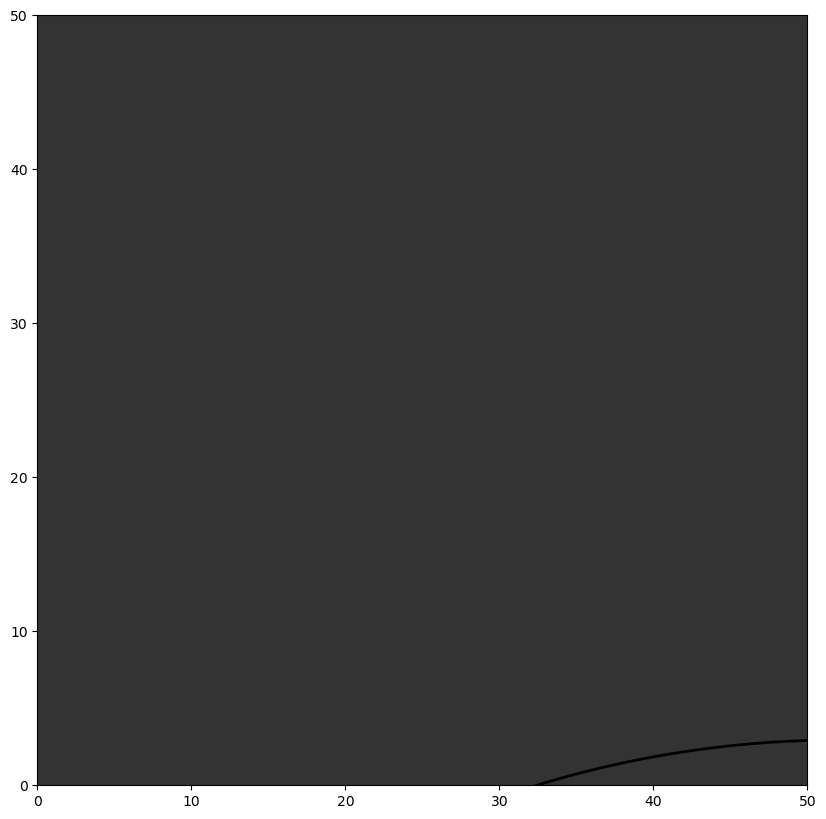

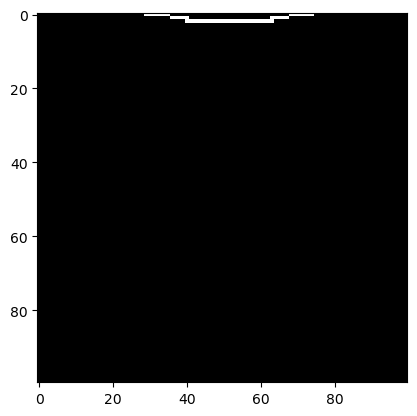

In [48]:
import matplotlib.pyplot as plt
import random
import math
import numpy as np
class City:
    def __init__(self, width, height):
        """ אתחול הלוח """
        self.width = width
        self.height = height
        self.board = np.zeros((height, width))  # לוח ייצוגי
    def mark_pixel(self, x, y, color):
        """ מסמן פיקסל על הלוח """
        if 0 <= int(x) < self.width and 0 <= int(y) < self.height:
            self.board[int(y)][int(x)] = color  # סימון נקודה בה הכביש עובר
    def show_city(self):
        """ מציג את הלוח """
        plt.imshow(self.board, cmap='gray')
        plt.show()
        
class Street:
    def __init__(self, board, street_length=1000, segment_length=5, street_width=2.0):
        self.board = board  # הלוח שעליו יופיע הכביש
        self.street_length = street_length
        self.segment_length = segment_length
        self.street_width = street_width
        self.points = []  # לשמור את נקודות ההתחלה של המקטעים
    def create_street(self):
        """ יוצר מקטעי כביש בצורה הרצויה עם עיקול ושומר את הנקודות """
        curve_factor = random.uniform(0, self.street_length / 4)  # גורם עיקול רנדומלי
        angle_offset = random.uniform(0, 2 * math.pi)  # זווית התחלתית רנדומלית
        # יצירת נקודת התחלה קרובה לראשית הצירים
        start_x = random.uniform(-10, 10)
        start_y = random.uniform(-10, 10)
        # יצירת נקודות הכביש
        self.points = []
        for i in range(int(self.street_length * 5)):  # כל 20 ס"מ
            t = i / (self.street_length * 5)
            angle = t * 2 * math.pi + angle_offset
            x = start_x + t * self.street_length + math.sin(angle) * curve_factor
            y = start_y + math.cos(angle) * curve_factor
            self.points.append((x, y))
            self.board.mark_pixel(x, y)  # סימון הנקודה בלוח
    def draw_road(self):
        """ מצייר את הכביש כקו רציף עם רוחב מוגדר """
        x_vals = [p[0] for p in self.points]
        y_vals = [p[1] for p in self.points]
        # ציור קו האמצע של הכביש
        plt.plot(x_vals, y_vals, color="black", linewidth=self.street_width)
    def generate_street(self):
        """ מייצרת כביש רנדומלי ומציירת אותו על הלוח """
        self.create_street()
        self.draw_road()
# דוגמת שימוש
board = Board(100, 100)
street = Street(board, street_length=100, street_width=2.0)
# יצירת הכביש
plt.figure(figsize=(10, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_facecolor((0.2, 0.2, 0.2))  # רקע כהה
street.generate_street()
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.show()
# הצגת הלוח עם הכביש
board.show_board()

In [50]:
def valid_place():
    pass

In [91]:
class City:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.mat = np.zeros((height, width))
        self.objects=[]
        self.obj_colors={
            'empty' : 0,
            'road': 1,
            'car': 2,
            'building': 3,
            'lake': 4,
            'person': 5,
            'tree': 6
        }
        
    def get_mat(self):
        return self.mat
    def get_pix(self, x, y):
        for k, v in self.obj_colors.items():
            if v == self.mat[x][y]:
                return k
        return "error"
    def set_pix(self, x, y, obj):
        
        self.mat[round(x)][round(y)] = self.obj_colors[obj]
        

    def get_obj_pix(self, obj):
        for i in range(my_city.height):
            for j in range(my_city.width):
                if my_city.get_pix(i,j) == 'empty':
                    print(my_city.get_pix(i,j),":",i ,", ",j)

In [97]:
import matplotlib.pyplot as plt
import random
import math

class Street:
    def __init__(self,city, street_length=1000, segment_length=5, street_width=2.0):
        self.city = city
        self.street_length = street_length
        self.segment_length = segment_length
        self.street_width = street_width
        self.points = []  # לשמור את נקודות ההתחלה של המקטעים
    def create_street(self):
        """יוצר מקטעי כביש בצורה הרצויה עם עיקול ושומר את הנקודות."""
        curve_factor = random.uniform(0, self.street_length / 4)  # גורם עיקול רנדומלי
        angle_offset = random.uniform(0, 2 * math.pi)  # זווית התחלתית רנדומלית
        # יצירת נקודת התחלה קרובה לראשית הצירים
        start_x = random.uniform(0, 20)
        start_y = random.uniform(0, 20)
        # יצירת נקודות הכביש
        self.points = []
        for i in range(int(self.street_length * 5)):  # כל 20 ס"מ
            t = i / (self.street_length * 5)
            angle = t * 2 * math.pi + angle_offset
            x = start_x + t * self.street_length + math.sin(angle) * curve_factor
            y = start_y + math.cos(angle) * curve_factor
            self.points.append((x, y))
            self.city.set_pix(x,y,'road')
        
                    
          
    def generate_street(self):
        """מייצרת כביש רנדומלי ומציירת אותו ב-Jupyter Notebook."""
        self.create_street()
my_city = City(1000, 1000)
street = Street(my_city,street_length=1000, street_width=30.0)
street.create_street()

road : 0 ,  944
road : 0 ,  945
road : 1 ,  945
road : 1 ,  946
road : 2 ,  946
road : 3 ,  946
road : 3 ,  947
road : 4 ,  947
road : 4 ,  948
road : 5 ,  948
road : 5 ,  949
road : 6 ,  949
road : 7 ,  949
road : 7 ,  950
road : 8 ,  950
road : 8 ,  951
road : 9 ,  951
road : 9 ,  952
road : 10 ,  952
road : 11 ,  952
road : 11 ,  953
road : 12 ,  953
road : 12 ,  954
road : 13 ,  954
road : 14 ,  955
road : 15 ,  955
road : 15 ,  956
road : 16 ,  956
road : 16 ,  957
road : 17 ,  957
road : 18 ,  958
road : 19 ,  958
road : 19 ,  959
road : 20 ,  959
road : 20 ,  960
road : 21 ,  960
road : 22 ,  960
road : 22 ,  961
road : 23 ,  961
road : 23 ,  962
road : 24 ,  962
road : 25 ,  963
road : 26 ,  963
road : 26 ,  964
road : 27 ,  964
road : 27 ,  965
road : 28 ,  965
road : 28 ,  966
road : 29 ,  966
road : 30 ,  966
road : 30 ,  967
road : 31 ,  967
road : 31 ,  968
road : 32 ,  968
road : 33 ,  968
road : 33 ,  969
road : 34 ,  969
road : 34 ,  970
road : 35 ,  970
road : 35 ,  97

road : 556 ,  99
road : 557 ,  99
road : 558 ,  99
road : 559 ,  99
road : 560 ,  99
road : 561 ,  98
road : 561 ,  99
road : 562 ,  98
road : 563 ,  98
road : 564 ,  98
road : 565 ,  98
road : 566 ,  98
road : 567 ,  97
road : 567 ,  98
road : 568 ,  97
road : 569 ,  97
road : 570 ,  97
road : 571 ,  97
road : 572 ,  96
road : 572 ,  97
road : 573 ,  96
road : 574 ,  96
road : 575 ,  96
road : 576 ,  96
road : 577 ,  96
road : 578 ,  95
road : 579 ,  95
road : 580 ,  95
road : 581 ,  95
road : 582 ,  94
road : 582 ,  95
road : 583 ,  94
road : 584 ,  94
road : 585 ,  94
road : 586 ,  94
road : 587 ,  93
road : 587 ,  94
road : 588 ,  93
road : 589 ,  93
road : 590 ,  93
road : 591 ,  93
road : 592 ,  92
road : 593 ,  92
road : 594 ,  92
road : 595 ,  92
road : 596 ,  91
road : 596 ,  92
road : 597 ,  91
road : 598 ,  91
road : 599 ,  91
road : 600 ,  91
road : 601 ,  90
road : 602 ,  90
road : 603 ,  90
road : 604 ,  90
road : 605 ,  89
road : 606 ,  89
road : 607 ,  89
road : 608 ,  

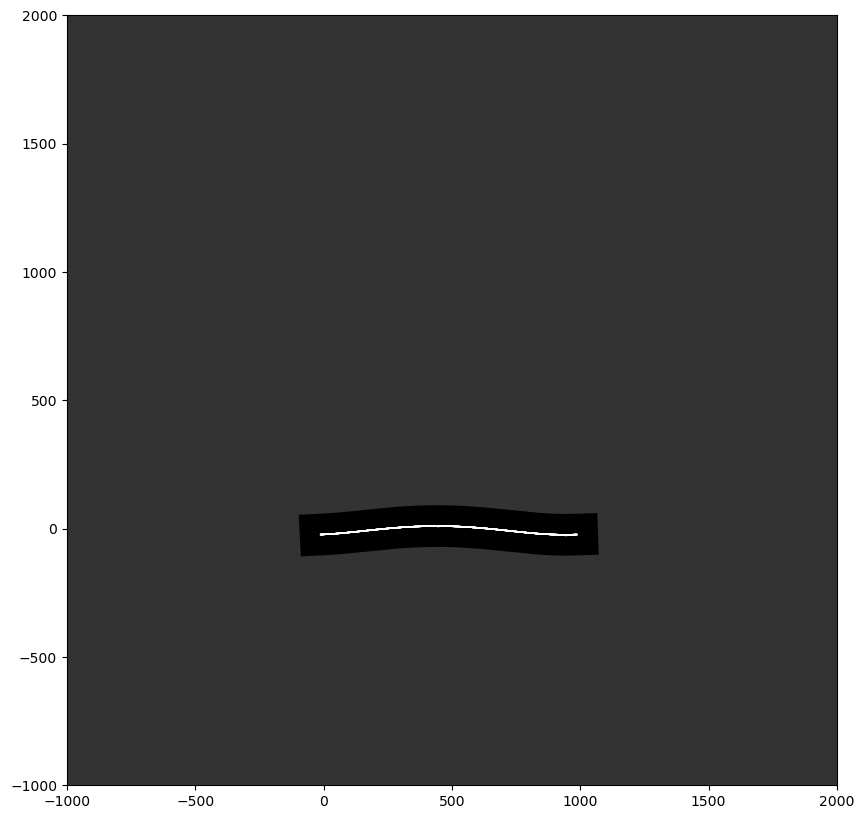

In [58]:
plt.figure(figsize=(10, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_facecolor((0.2, 0.2, 0.2))  # רקע כהה
street.generate_street()
plt.xlim(-1000, 2000)
plt.ylim(-1000, 2000)
plt.show()